In [167]:
import numpy as np
import glob
import os
import networkx as nx
import matplotlib.pyplot as plt
from os.path import join
from collections import defaultdict
from numpy import linalg as LA
import heapq
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict
import random
from pylab import *
import sys
from munkres import Munkres

##### path to main folders 

In [55]:
path_to_egonet='/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/egonets'
path_to_circle='/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/circles'

## Utils functions

> ##### Load the ergonet data for a facebook user

In [105]:
def buildGraph(filename):
    egonets=[]
    with open(join(path_to_egonet,filename)) as f:
        nodes_list = f.read().split('\n')
        for node in nodes_list:
            if node!="" and  ":" in node:
                node_split = node.split(': ')
                egonets.append([node_split[0], [a for a in node_split[1].split(' ') if a!='']])
    G = nx.Graph()
    node_names=[]
    node_name_isolated=[]
    for node in egonets:
        if len(node[1])==0:
            node_name_isolated.append(node[0])
        else:
            node_names.append(node[0])
        for edge in node[1]:
            G.add_edge(node[0], edge)
    return G,node_names,node_name_isolated

> ##### Load Circle 

In [36]:
def loadCircle(filename):
    circle_dict={}
    with open(join(path_to_circle,filename)) as f:
        circle_list = f.read().split('\n')
        for circle in circle_list:
            if circle!="" and  ":" in circle:
                circle_split = circle.split(': ')
                circle_dict[circle_split[0]]=[a for a in circle_split[1].split(' ') if a!='']
    return circle_dict

> #####  Build Adjacency matrix 

In [190]:
def buildAdj(graph):
    A = nx.adjacency_matrix(graph)
    return(A.todense())

> ##### Build Kronecker Matrix for communities

In [191]:
def buildKroneckerMat(circle_dict,adjacent,node_names):
    knonecker=np.zeros((adjacent.shape[0],adjacent.shape[0]))
    for c in circle_dict:
        circle=circle_dict[c]
        for i in range(len(circle)):
            if circle[i] in node_names:
                ix0=node_names.index(circle[i])
            else:
                continue
            for j in range(i,len(circle)):
                if circle[j] in node_names:
                    iy0=node_names.index(circle[j])
                else:
                    continue
                if knonecker[ix0,iy0]==0:
                    knonecker[ix0,iy0]=1
                if knonecker[iy0,ix0]==0:
                    knonecker[iy0,ix0]=1
    return knonecker
    

> ##### Compute the diagonal matrix of an adjacent matrix  and its invert

In [192]:
def computeDegreeMatrix(adjacent):
    size=adjacent.shape[0]
    diagonal=np.dot(adjacent,np.ones(size).reshape(size,1))

    return np.diagflat(diagonal)
def invDegreeMatrix(Degree):
    size=Degree.shape[0]
    invert=np.zeros((size,size))
    for i in range(size):
        invert[i,i]=1.0/Degree[i,i]
    return invert 
    

> ##### Compute the laplacian 

In [193]:
def lapalacian(DegreeMat,AdjMat):
    return DegreeMat-AdjMat

> ##### Compute modularity for a given graph partition


> ##### Simple modularity

In [194]:
def computeModularity(adjacent,degreeMatrix,kroneckerMat):
    degree_vec=np.diag(degreeMatrix)
    size=len(degree_vec)
    m=np.sum(adjacent)/2.0
    kikjsur2m=(1/(2*m))*np.dot(degree_vec.reshape(size,1),degree_vec.reshape(1,size))
    return (1/(2*m))*np.sum(np.multiply((np.add(adjacent,-kikjsur2m)),kroneckerMat))

> ##### Extended modularity

In [418]:
def computeImportanceInCom(circles_ves,adjacent,node_names):
    node_imp={}
    circles=list(circles_ves.values())
    for cl in circles_ves:
        this_w=[0]*len(node_names)
        for node in node_names:
            ix=node_names.index(node)
            number=computeFriend(adjacent[node_names.index(node),:].tolist()[0],node_names,circles_ves[cl],node)
            node_imp[node_names.index(node)]=number
        node_imp[cl]=node_imp
    return node_imp    

In [415]:
def extendedModularity(adjacent,degreeMatrix,circle_vec):
    std=np.std(circle_vec)
    average=np.mean(circle_vec)
    ncir=[(a-average)/std for a in circle_vec]
    vec_cir=np.array(ncir).reshape(len(ncir),1)
    mat=np.dot(vec_cir,vec_cir.T)
    degree_vec=np.diag(degreeMatrix)
    size=len(degree_vec)
    m=np.sum(adjacent)/2.0
    kikjsur2m=(1/(m))*np.dot(degree_vec.reshape(size,1),degree_vec.reshape(1,size))
    return (1/(2*m))*np.sum(np.multiply((np.add(adjacent,-kikjsur2m)),mat))

In [416]:
def computeExtendedModularity(adjacent,degreeMatrix,circle_vecs):
    somme=0
    for circle_vec in circle_vecs:
        somme+=extendedModularity(adjacent,degreeMatrix,circle_vec)
    return somme

> ##### Matrice of K eigenvectors of the laplacian matrix

In [384]:
def matKeigOfLap(invDegree,Lap):
    V=[]
    eigenval, eigenvec = LA.eig(np.dot(invDegree,Lap))
    #index of k greatest eigenvalues
    kmost=list(heapq.nlargest(invDegree.shape[0],range(len(eigenval)),key=eigenval.__getitem__))
    eigenval_ordered=[eigenval[a] for a in kmost]
    deltaEig=[abs(eigenval_ordered[i]-eigenval_ordered[i+1]) for i in range(invDegree.shape[0]-1)]
    plt.plot(eigenval_ordered,'--bo')
    plt.xlabel('k')
    plt.ylabel('eigenvalues')
    plt.show()
    liste=list(heapq.nlargest(len(deltaEig),range(len(deltaEig)),key=deltaEig.__getitem__))
    koptimal=liste[1]+2
    koptimal=min(koptimal,10)
    #deltaEig.index(max(deltaEig))+2
    for i in kmost:
        V.append(eigenvec[:,i].reshape(invDegree.shape[0],1))
    return np.hstack(V)[:,:koptimal]

> ##### k-Way (Normalized) Spectral Clustering 

In [281]:
def buildDisCluster(invdiag,Lap,node_names):
    data=matKeigOfLap(invdiag,Lap)
    k=data.shape[1]
    k_means = KMeans(k)
    k_means.fit(data) 
    labels = k_means.labels_
    setLabels=set(labels)
    all_clus_dis=[]
    for sl in setLabels:
        ixs=[i for i,v in enumerate(labels) if v==sl]
        all_clus_dis.append([node_names[j] for j in ixs])
    return(all_clus_dis)


> ##### Louvain Method

In [348]:
def initializeCommunnity(node_names):
    ini_clus={}
    for node in node_names:
       ini_clus[node]=[node]
    return ini_clus

In [356]:
def runLouvainAlgo(ini_clus,adjacent,degreeMatrix,node_names):
    kro=buildKroneckerMat(ini_clus,adjacent,node_names)
    mod=computeModularity(adjacent,degreeMatrix,kro)
    clus_dict_cop=ini_clus.copy()
    for vi in ini_clus:
        count=0
        prec=clus_dict_cop[vi]
        del clus_dict_cop[vi]
        all_mod=[]
        for vj in clus_dict_cop:
            clus_dict_cop[vj]=clus_dict_cop[vj]+prec
            kro=buildKroneckerMat(clus_dict_cop,adjacent,node_names)
            mod=computeModularity(adjacent,degreeMatrix,kro)
            all_mod.append((vj,mod))
            clus_dict_cop[vj]=[a for a in clus_dict_cop[vj] if a not in prec]
            count+=1
            
        score=[b[1] for b in all_mod]
        if max(score)>mod and count<100000:
            ix_max=score.index(max(score))
            clus_dict_cop[all_mod[ix_max][0]]=clus_dict_cop[all_mod[ix_max][0]]+prec
            mod=max(score)
        else:
            clus_dict_cop[vi]=prec
            return clus_dict_cop
    

> ##### Overlap communities

In [321]:
def computeFriend(line,node_names,cl,node):
    count=0
    for c in cl:
        if line[node_names.index(c)]!=0:
            count+=1
    return count
    
def overlapCom(adjacent,node_names,all_clusters):
    for node in node_names:
        count_link=np.sum(adjacent[node_names.index(node),:].tolist()[0])
        for cl in all_clusters:
            if node not in cl:
               cc=computeFriend(adjacent[node_names.index(node),:].tolist()[0],node_names,cl,node)
               if cc/count_link>=0.25:
                  cl.append(node)  
    return all_clusters
            
            

### Computing the score of predictions 

First score KPI : based on the comparison of number of communities between truth and prediction

In [326]:
def error_com(dico_t, dico_p):
    """
    this function gives the error rate about the number of communities between truth and prediction
    dico_t : truth dictionary. Here, circles.
    dico_p : dico of predictions
    """
    comm_error_rate = {}
    for user in list(dico_p.keys()):
        comm_count_truth = len(dico_t[user])
        comm_count_pred = len(dico_p[user])
        error = (np.abs(comm_count_truth - comm_count_pred))/comm_count_truth
        comm_error_rate[user]= 1 - error
    return comm_error_rate

In [375]:
def f1_score(dico_t, dico_p):
    """
    This function computes the F1 score for each true community with the predicted communities, 
    and keep the best one among them.
    """
    f1_dico = {}
    for user in list(dico_p.keys()):
        f1_dico[user]=[]
        for community_t in dico_t[user]:
            f1_community = []
            for community_p in dico_p[user]:
                tp = list(set(community_t).intersection(set(community_p)))
                f1 = 2.0*len(tp)/(len(community_t)+len(community_p))
                f1_community.append(f1)
            if f1_community == []:
                f1_dico[user].append(0)
            else:
                f1_dico[user].append(max(f1_community))
    return f1_dico

## Fitting the training data 

In [226]:
files=[f.split('.')[0] for f in os.listdir(path_to_egonet) if f.split('.')[0]!='']
files_train, files_test = train_test_split(files, test_size=0.20, random_state=42)

> ##### Load graph and circles for training and testing set

In [106]:
all_graph_train={file:(buildGraph(file+'.egonet')) for file in files_train}
all_circle_train={file:loadCircle(file+'.circles') for file in files_train}
all_graph_test={file:(buildGraph(file+'.egonet')) for file in files_test}
all_circle_test={file:loadCircle(file+'.circles') for file in files_test}

### Basic properties of the graph for the training set

> ##### compute number of nodes, number of edges and average degree per node in graph

In [153]:
average_degree=[]
number_of_node=[]
number_of_edge=[]
for g in all_graph_train:
    number_of_node.append(len(all_graph_train[g][0]))
    number_of_edge.append(all_graph_train[g][0].number_of_edges())
    average_degree.append(2*all_graph_train[g][0].number_of_edges()/len(all_graph_train[g][0]))

> ##### compute the number of triangles 

In [165]:
number_of_triangle=[]
for gid in all_graph_train:
    g=all_graph_train[gid][0]
    number_of_triangle.append(np.sum(list(nx.triangles(g).values()))/(len(g)*6.0))

> ##### compute the clustering coefficient 

In [186]:
clustering_coefficients=[]
for gid in all_graph_train:
    g=all_graph_train[gid][0]
    clustering_coefficients.append(nx.average_clustering(g))

#### Properties of the communities in the training set

> ##### Number of communities per Ego Network

In [76]:
number_of_com=[len(all_circle_train[circle].keys()) for circle in all_circle_train]

> ##### Modularity per graph

In [114]:
training_modularities=[]
for g in all_graph_train:
    adjacent=buildAdj(all_graph_train[g][0])
    degreeMatrix=computeDegreeMatrix(adjacent)
    kroneckerMat=buildKroneckerMat(all_circle_train[g],adjacent,all_graph_train[g][1])
    training_modularities.append(computeModularity(adjacent,degreeMatrix,kroneckerMat))

> ##### Extended modularity

In [ ]:
adjacent=buildAdj(all_graph_train['0'][0])
degreeMatrix=computeDegreeMatrix(adjacent)
kroneckerMat=buildKroneckerMat(all_circle_train[g],adjacent,all_graph_train[g][1])
training_modularities.append(computeModularity(adjacent,degreeMatrix,kroneckerMat))

circle_vecs=computeImportanceInCom(circles,adjacent,node_names)
computeExtendedModularity(adjacent,degreeMatrix,circle_vecs)

#### Training set summary

In [188]:
training_graph_dict={'# nodes':number_of_node,'# edges':number_of_edge,'average degree':average_degree,'# of triangles':number_of_triangle,'# communities':number_of_com,'modularity':training_modularities,'clustering coefficient':clustering_coefficients}
training_graph_summary=pd.DataFrame(training_graph_dict)
training_graph_summary.index=all_graph_train.keys()
training_graph_summary.head(10)

,# communities,# edges,# nodes,# of triangles,average degree,clustering coefficient,modularity
24758,5,97,44,1.034091,4.409091,0.641198,-0.008742
11014,10,2350,330,14.280303,14.242424,0.612121,0.000798
25159,14,955,119,26.932773,16.050420,0.686625,-0.015238
9846,9,1021,100,26.125000,20.420000,0.643935,-0.008077
2738,4,51,37,0.351351,2.756757,0.496118,-0.040465
18612,8,2285,225,31.708889,20.311111,0.607578,-0.015606
14129,9,7807,665,39.916541,23.479699,0.538740,-0.000879
23299,15,2221,461,6.007592,9.635575,0.532423,0.001855
22650,12,1159,169,14.857988,13.715976,0.656910,-0.023496
7667,5,3632,311,30.020900,23.356913,0.565345,-0.006619


##### Some statistics

In [290]:
average_num_of_com=np.mean(training_graph_summary)
print(average_num_of_com)

# communities                9.590909
# edges                   3459.727273
# nodes                    246.329545
# of triangles              52.625625
average degree              21.052330
clustering coefficient       0.612476
modularity                  -0.006762
dtype: float64


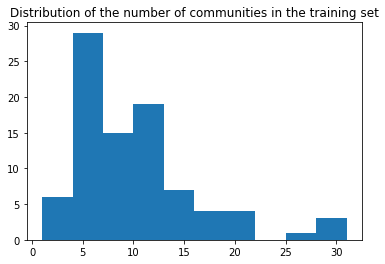

In [177]:
plt.hist(training_graph_summary['# communities'])
plt.title('Distribution of the number of communities in the training set')
plt.show()

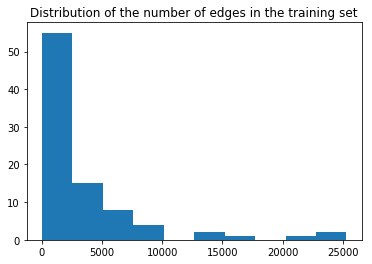

In [178]:
plt.hist(training_graph_summary['# edges'])
plt.title('Distribution of the number of edges in the training set')
plt.show()

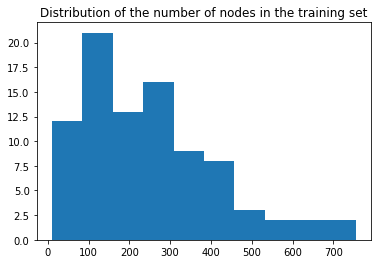

In [179]:
plt.hist(training_graph_summary['# nodes'])
plt.title('Distribution of the number of nodes in the training set')
plt.show()

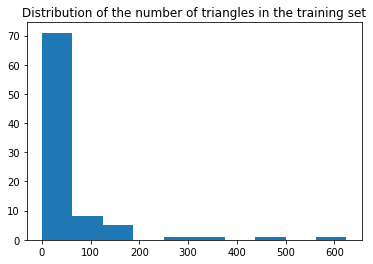

In [181]:
plt.hist(training_graph_summary['# of triangles'])
plt.title('Distribution of the number of triangles in the training set')
plt.show()

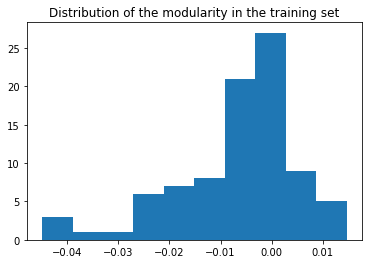

In [185]:
plt.hist(training_graph_summary['modularity'])
plt.title('Distribution of the modularity in the training set')
plt.show()

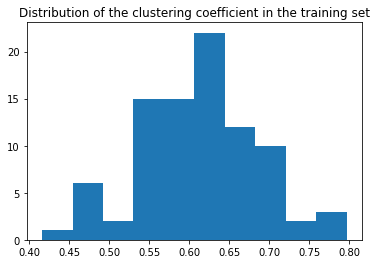

In [189]:
plt.hist(training_graph_summary['clustering coefficient'])
plt.title('Distribution of the clustering coefficient in the training set')
plt.show()

### Running k-way spectral clustering

In [346]:
all_clus={}
all_clus_count={}
all_clusters={}
all_clusters_count={}
for file in all_graph_test:
    G,node_names,node_name_isolated= buildGraph(file+".egonet")
    adj=buildAdj(G)
    diag=computeDegreeMatrix(adj)
    invdiag=invDegreeMatrix(diag)
    Lap=lapalacian(diag,adj)
    clusters=buildDisCluster(invdiag,Lap,node_names)
    all_clus[file]=clusters
    all_clus_count[file]=[len(a) for a in clusters]
    all_clusters[file]=overlapCom(adj,node_names,clusters)
    all_clusters_count[file]=[len(a) for a in all_clusters[file]]

In [378]:
restric_circle_test_k={}
for k in all_circle_test:
    dict1=all_circle_test[k]
    dict1_values=dict1.values()
    restric_circle_test_k[k]=dict1_values

### Louvain Method 1

In [358]:
all_clus_louvain={}
all_clus_count_louvain={}
all_clusters_louvain={}
all_clusters_count_louvain={}
count=0
for file in all_graph_test:
    print(file)
    count+=1
    if count<15:
        G,node_names,node_name_isolated= buildGraph(file+".egonet")
        adj=buildAdj(G)
        diag=computeDegreeMatrix(adj)
        invdiag=invDegreeMatrix(diag)
        ini_clus=initializeCommunnity(node_names)
        clusters_dic=runLouvainAlgo(ini_clus,adj,diag,node_names)
        clusters=list(clusters_dic.values())
        all_clus_louvain[file]=clusters
        all_clus_count_louvain[file]=[len(a) for a in clusters]
        all_clusters_louvain[file]=overlapCom(adj,node_names,clusters)
        all_clusters_count_louvain[file]=[len(a) for a in all_clusters_louvain[file]]
    else:
        break

5087
3581
2630
6726
611
16642
22364
13687
22824
10929
8338
24812
850
1813
18005


In [360]:
resK=[k for k in all_clusters_louvain]
restric_circle_test={k:v for k,v in all_circle_test.items() if k in resK}

In [372]:
restric_circle_test1={}
for k in resK:
    dict1=restric_circle_test[k]
    dict1_values=dict1.values()
    restric_circle_test1[k]=dict1_values

In [420]:
G,node_names,node_name_isolated= buildGraph("239.egonet")
adjacent=buildAdj(G)
degreeMatrix=computeDegreeMatrix(adjacent)

circle_vecs=computeImportanceInCom(all_circle_train['239'],adjacent,node_names)
computeExtendedModularity(adjacent,degreeMatrix,circle_vecs)

KeyError: '239'

## Evauation of the results

> ##### K-way Clustering

In [399]:
all_clusters_df=pd.DataFrame()
all_clusters_df['users']=list(all_clusters.keys())
all_clusters_df['prediction']=list(all_clusters.values())
all_clusters_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/k_way_pred.csv')

In [379]:
error_com_kway=error_com(restric_circle_test_k,all_clusters)

In [394]:
error_com_kway_df=pd.DataFrame()
error_com_kway_df['keys']=list(error_com_kway.keys())
error_com_kway_df['error_com']=list(error_com_kway.values())
error_com_kway_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/k_way_error_com.csv')

In [380]:
f1_score_kway=f1_score(restric_circle_test_k,all_clusters)

In [395]:
f1_score_kway_df=pd.DataFrame()
f1_score_kway_df['keys']=list(f1_score_kway.keys())
f1_score_kway_df['f1_score']=list(f1_score_kway.values())
f1_score_kway_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/k_way_f1_score.csv')

> ##### Louvain method

In [400]:
all_clusters_louvain_df=pd.DataFrame()
all_clusters_louvain_df['users']=list(all_clusters_louvain.keys())
all_clusters_louvain_df['prediction']=list(all_clusters_louvain.values())
all_clusters_louvain_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/louvain_pred.csv')

In [373]:
error_com_louvain=error_com(restric_circle_test1,all_clusters_louvain)

In [397]:
error_com_louvain_df=pd.DataFrame()
error_com_louvain_df['keys']=list(error_com_louvain.keys())
error_com_louvain_df['error_com']=list(error_com_louvain.values())
error_com_louvain_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/louvain_error_com.csv')

In [376]:
f1_score_louvain=f1_score(restric_circle_test1,all_clusters_louvain)

In [398]:
f1_score_louvain_df=pd.DataFrame()
f1_score_louvain_df['keys']=list(f1_score_louvain.keys())
f1_score_louvain_df['f1_score']=list(f1_score_louvain.values())
f1_score_louvain_df.to_csv('/Users/yaguethiam/Centrale_3A/NGSA/final_project/anonData/louvain_f1_score.csv')

### Some characteristics of the community

In [ ]:
def get_degrees(G):
    """
    This function returns the list of degrees of nodes of a given graph
    """
    degrees=[]
    for node_degree in list(nx.degree(G)):
        degrees.append(node_degree[1])
    return degrees

In [ ]:
def FOMD(sub, dm):
    """
    Returns the Fraction Over Median Degree of a community 
    """
    count=0
    sub_degrees = get_degrees(sub)
    for sub_degree in sub_degrees:
        if sub_degree>dm:
            count+=1
    fomd = count/nx.number_of_nodes(sub)
    return fomd

In [ ]:
def get_ext_edges(sub, G):
    """
    Return the number of external edges of a community
    """
    nodes_int_degree = list(nx.degree(sub))
    node_sub_dict = {}
    for node in nodes_int_degree:
        node_sub_dict[node[0]]=node[1]
    nodes_degree = list(nx.degree(G))
    for node in nodes_degree:
        if node[0] in list(node_sub_dict.keys()):
            int_deg = node_sub_dict[node[0]]
            node_sub_dict[node[0]] = node[1] - int_deg
    cs = sum(list(node_sub_dict.values()))
    return cs